<a href="https://colab.research.google.com/github/matheusalsilva98/fiocruz_barbeiro/blob/main/model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://medium.com/ai-techsystems/insect-classification-2c89e7398ec4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

In [ ]:
# Directory where images are present
main_dir = '/content/drive/MyDrive/5.1/fiocruz/model1/dataset_train_val_model1'
test_dir = '/content/drive/MyDrive/5.1/fiocruz/model1/dataset_test_model1'
num_fldrs = 2
target_size=(150,150)

In [ ]:
# dictionary of labels
insect_names = {'1':"barbeiro",'2':"nao_barbeiro"}

In [ ]:
def getdata(folder_path,num_subfolders):
    global insect_names
    insects = pd.DataFrame(columns=['image_abs_path','image_labels'])
    for label in range(1,num_subfolders+1):
        #print("processing for label: {}".format(label))
        label_i = folder_path+"/"+insect_names[str(label)]
        #read directory
        dirs_label_i =  os.listdir(label_i)
        idx = 0
        for image in dirs_label_i:
            #create a absolute image path
            insect_i = os.path.join(label_i,image)
            #print('Absolute path for image no. {} and label {}: {}'\
                  #.format(idx,label,flower_i))

            #fill the dataframe with path and label
            insects = insects.append({'image_abs_path':insect_i,
                            'image_labels':insect_names[str(label)]},
                           ignore_index=True)
            idx += 1
    return insects

In [ ]:
train = getdata(main_dir,num_fldrs)

In [ ]:
def datapreprocessing(main_dir,bsize):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    train_gen = ImageDataGenerator(rescale=1.0/255,
                                  validation_split=0.30,
                                  rotation_range=40,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

    train_generator = train_gen.flow_from_directory(
        directory=main_dir,
        target_size=target_size,
        batch_size=bsize,
        color_mode="rgb",
        shuffle=True,
        subset="training",
        class_mode='categorical')

    valid_generator = train_gen.flow_from_directory(
        directory=main_dir,
        target_size=target_size,
        batch_size=bsize,
        color_mode="rgb",
        shuffle=True,
        subset="validation",
        class_mode='categorical')

    return train_generator, valid_generator

In [ ]:
# Build train and validation sets
traingen,validgen = datapreprocessing(main_dir,20)

Found 572 images belonging to 2 classes.
Found 243 images belonging to 2 classes.


In [ ]:
def visualize_gen(train_generator):
    #Visualising Images Processed
    plt.figure(figsize=(12, 6))
    for i in range(0, 10):
        plt.subplot(2, 5, i+1)
        for X_batch, Y_batch in train_generator:
            image = X_batch[0]
            plt.title('barbeiro' if Y_batch[0][0]==1.0 else 'nao_barbeiro')
            plt.axis("off")
            plt.imshow((image*255).astype(np.uint8))
            break
    plt.tight_layout()
    plt.show()

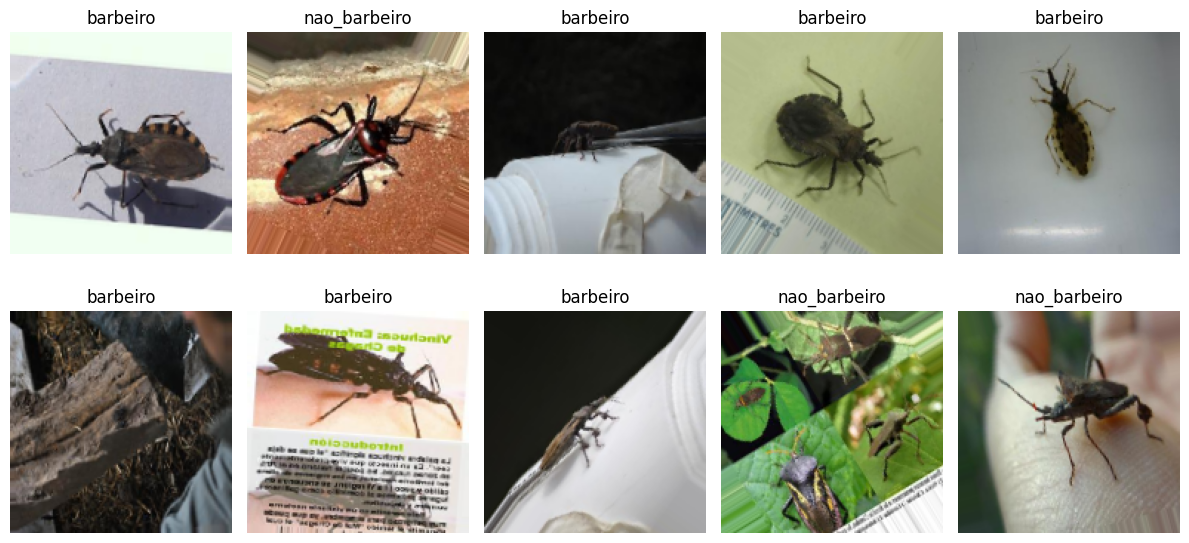

In [ ]:
visualize_gen(traingen)

In [ ]:
def insectclf(input_shape):
    from tensorflow import keras as ks
    #from tensorflow.keras import regularizers
    model = ks.models.Sequential()
    #building architecture
    #Adding layers
    model.add(ks.layers.Conv2D(16,(3,3),
                               strides=1,
                               activation="relu",
                               padding='valid',
                               name="layer1",
                               input_shape=input_shape))
    model.add(ks.layers.MaxPooling2D(pool_size=4))
    model.add(ks.layers.Dropout(0.3))
    model.add(ks.layers.Conv2D(32,(3,3),strides=1,padding="valid",activation="relu",name="layer2"))
    model.add(ks.layers.MaxPooling2D(pool_size=2))
    model.add(ks.layers.Dropout(0.3))
    model.add(ks.layers.Conv2D(64,(3,3),strides=1,padding="valid",activation="relu",name="layer3"))
    model.add(ks.layers.MaxPooling2D(pool_size=2))
    model.add(ks.layers.Dropout(0.3))
    model.add(ks.layers.Conv2D(128,(3,3),strides=1,padding="valid",activation="relu",name="layer4"))
    model.add(ks.layers.MaxPooling2D(pool_size=2))
    model.add(ks.layers.Dropout(0.3))

    model.add(ks.layers.Flatten())
    model.add(ks.layers.Dense(128,activation="relu",
                              name="layer7"))
    model.add(ks.layers.Dropout(0.5))
    model.add(ks.layers.Dense(128,activation="relu",
                              name="layer8"))
    model.add(ks.layers.Dropout(0.5))

    model.add(ks.layers.Dense(2,activation="softmax",
                              name="output"))#2 classes
    model.summary()

    return model

In [ ]:
# Get input shape
input_shape = traingen.image_shape
#Build Model
model = insectclf(input_shape)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 37, 37, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_30 (Dropout)        (None, 37, 37, 16)        0         
                                                                 
 layer2 (Conv2D)             (None, 35, 35, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 17, 17, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_31 (Dropout)        (None, 17, 17, 32)       

In [ ]:
def compiler(model,train_generator,valid_generator,epchs,bsize,lr=0.0001):

    from tensorflow import keras as ks
    callbck = ks.callbacks.EarlyStopping(monitor='val_loss',patience=20,
                                         verbose=2,restore_best_weights=True)
    #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)
    opt = ks.optimizers.Adam(learning_rate=lr)

    model.compile(loss="binary_crossentropy",
                      optimizer=opt,
                      metrics=tf.keras.metrics.BinaryAccuracy(name='accuracy'))
    history = model.fit(train_generator,
                        epochs=epchs,
                        callbacks=[callbck],
                        validation_data=valid_generator,
                        verbose = 1,
                        steps_per_epoch = train_generator.n//bsize,
                        validation_steps = valid_generator.n//bsize
                        )
    #Visualise curves
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='valid_acc')

    plt.title('lrate='+str(lr), pad=-50)
    plt.legend()
    plt.grid(True)
    return model,history

Epoch 1/100
17/17 [==============================] - 8s 363ms/step - loss: 0.6537 - accuracy: 0.6294 - val_loss: 0.6752 - val_accuracy: 0.6500
Epoch 2/100
17/17 [==============================] - 6s 391ms/step - loss: 0.6510 - accuracy: 0.6777 - val_loss: 0.6632 - val_accuracy: 0.6357
Epoch 3/100
17/17 [==============================] - 5s 315ms/step - loss: 0.6338 - accuracy: 0.6777 - val_loss: 0.6338 - val_accuracy: 0.6857
Epoch 4/100
17/17 [==============================] - 7s 433ms/step - loss: 0.6076 - accuracy: 0.6717 - val_loss: 0.6194 - val_accuracy: 0.6786
Epoch 5/100
17/17 [==============================] - 6s 323ms/step - loss: 0.6166 - accuracy: 0.6416 - val_loss: 0.6225 - val_accuracy: 0.6571
Epoch 6/100
17/17 [==============================] - 7s 420ms/step - loss: 0.5694 - accuracy: 0.6971 - val_loss: 0.6559 - val_accuracy: 0.6500
Epoch 7/100
17/17 [==============================] - 6s 377ms/step - loss: 0.5810 - accuracy: 0.6958 - val_loss: 0.6177 - val_accuracy: 0.7214

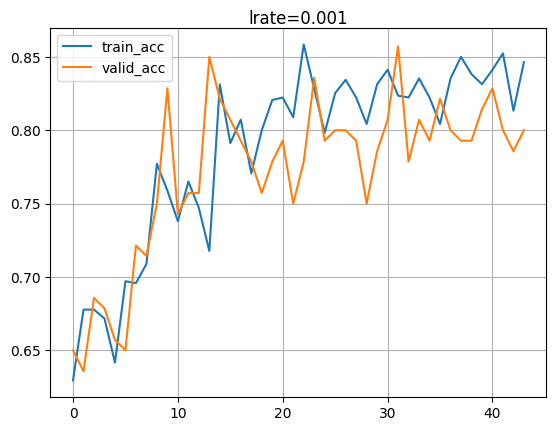

In [ ]:
model = compiler(model,traingen,validgen,100,bsize=32,lr=0.001)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image
from tensorflow import keras as ks

uploaded = files.upload()

print(uploaded)

for fn in uploaded.keys():
  # predicting images
  print(fn)
  path = '/content/' + fn
  img = image.load_img(path, target_size=target_size)
  plt.imshow(img)
  input_arr = tf.keras.preprocessing.image.img_to_array(img)
  input_arr = np.array([input_arr])  # Convert single image to a batch.
  predictions = np.argmax(tf.nn.softmax(load_model.predict(input_arr)), axis=-1)
  #our dictionary starts from 1 whereas model has classes from 0.
  print(insect_names[str(predictions[0]+1)])


In [ ]:
load_model = tf.keras.models.load_model('/content/drive/MyDrive/5.1/fiocruz/model1/results_model1_arc1/Model1_18_03_training2.tf')

1/1 [==============================] - 0s 17ms/step
87.5 70.0


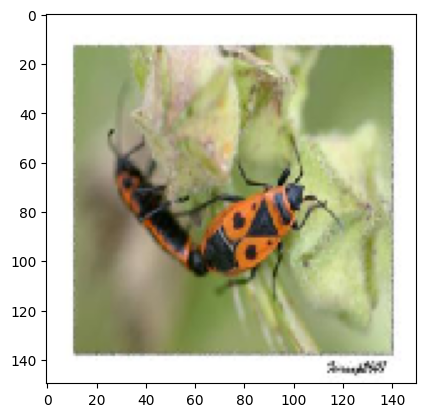

In [ ]:
# Rotina para verificar quantos acertos, de acordo com o dataset de barbeiro e não barbeiro,
# qual a porcentagem de acerto para cada um

from glob import glob
from collections import defaultdict

def calc_porcentagem_acerto(test_dir, str_barb_ou_nao):
  dict_info = defaultdict(list)
  if str_barb_ou_nao != 'barbeiro' and str_barb_ou_nao != 'nao_barbeiro':
    return 'se espera como input "barbeiro" ou "nao_barbeiro"'
  lista_de_caminhos = glob(test_dir + f'/{str_barb_ou_nao}/*.*')
  for path in lista_de_caminhos:
    dict_info['imgs'].append(path)
    img = image.load_img(path, target_size=target_size)
    plt.imshow(img)
    input_arr = tf.keras.preprocessing.image.img_to_array(img)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    predictions = np.argmax(tf.nn.softmax(load_model.predict(input_arr)), axis=-1)
    if insect_names[str(predictions[0]+1)] != str_barb_ou_nao:
      continue
    dict_info['correto'].append(path)
  return (len(dict_info['correto']) / len(dict_info['imgs'])) * 100


porc_barbeiro = calc_porcentagem_acerto(test_dir, 'barbeiro')
porc_n_barbeiro = calc_porcentagem_acerto(test_dir, 'nao_barbeiro')

print(porc_barbeiro, porc_n_barbeiro)

In [ ]:
model01[0].save(filepath='',save_format="tf")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1.0/255,
                              validation_split=0.9,
                              rotation_range=40,
                              horizontal_flip=True,
                              fill_mode='nearest')

testgen = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=target_size,
    batch_size=20,
    color_mode="rgb",
    shuffle=False,
    subset="validation",
    class_mode='categorical')

Found 70 images belonging to 2 classes.


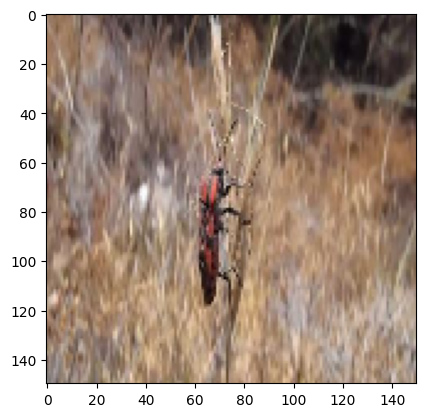

In [ ]:
  img = image.load_img(path, target_size=target_size)
  plt.imshow(img)
  input_arr = tf.keras.preprocessing.image.img_to_array(img)
  input_arr = np.array([input_arr])

In [ ]:
for X_batch, Y_batch in testgen:
  Y_batch[0]
  break

In [ ]:
def visualize_test_gen(test_generator):
    #Visualising Test Images Processed
    plt.figure(figsize=(12, 6))
    for i in range(0, 10):
        plt.subplot(2, 5, i+1)
        for X_batch, Y_batch in test_generator:
            image = X_batch[0]
            image2 = np.array([image])
            predictions = np.argmax(tf.nn.softmax(model01[0].predict(image2)), axis=-1)
            #our dictionary starts from 1 whereas model has classes from 0.
            plt.axis("off")
            plt.title(insect_names[str(predictions[0]+1)])
            plt.imshow((image*255).astype(np.uint8))
            break

1/1 [==============================] - 0s 43ms/step


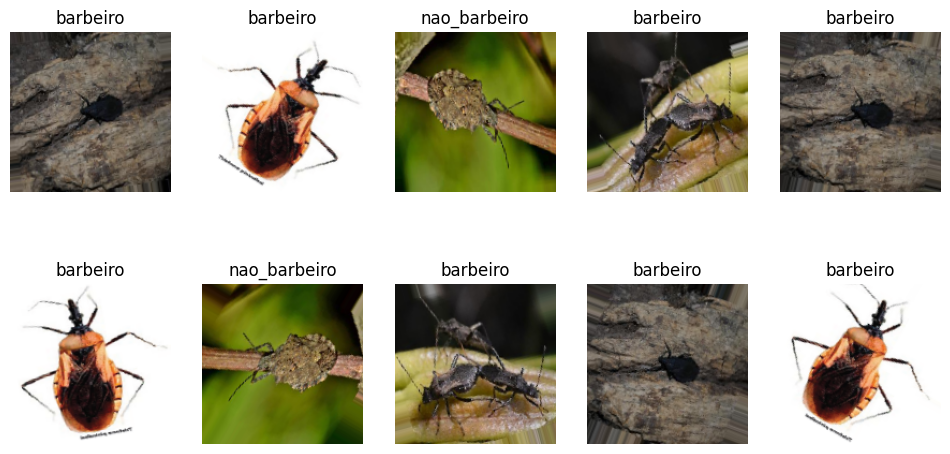

In [ ]:
visualize_test_gen(testgen)